In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# загружаем данные
data = pd.read_csv('data/train.csv', low_memory=False)

data.head()

id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN

In [3]:
# группируем продажи по магазину 25
mask = data['store_nbr'] == 25

grouped_data = (
    data[mask]
    .groupby('date', as_index=False)['unit_sales']
    .sum()
    .rename({'unit_sales': 'sales'}, axis=1)
)

grouped_data.head()

date     sales
0  2013-01-01  2511.619
1  2013-01-02  5316.224
2  2013-01-03  4442.913
3  2013-01-04  4844.354
4  2013-01-05  5817.526

In [4]:
# приводим индексы к стандарту pd.Datetime
grouped_data = grouped_data.set_index(pd.DatetimeIndex(grouped_data['date'])) 
grouped_data = grouped_data.drop('date', axis=1)

grouped_data.head()

sales
date                
2013-01-01  2511.619
2013-01-02  5316.224
2013-01-03  4442.913
2013-01-04  4844.354
2013-01-05  5817.526

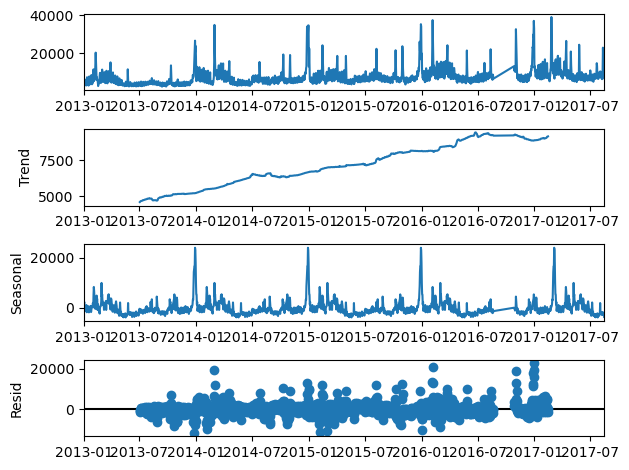

In [5]:
# выполним сезонную декомпозицию
decomposition = seasonal_decompose(
    grouped_data, 
    model='additive', 
    period=365
) 

decomposition.plot()
plt.show()

In [6]:
print('Количесиво элементов в выборке =', grouped_data.shape[0])
print('Количесиво элементов в шумовой части =', decomposition.resid.shape[0])
print('Количесиво числовых элементов в шумовой части =', decomposition.resid.dropna().shape[0])
print('Количесиво элементов в сезонной части =', decomposition.seasonal.shape[0])
print('Количесиво числовых элементов в трендовой части =', decomposition.trend.dropna().shape[0])

Количесиво элементов в выборке = 1618
Количесиво элементов в шумовой части = 1618
Количесиво числовых элементов в шумовой части = 1254
Количесиво элементов в сезонной части = 1618
Количесиво числовых элементов в трендовой части = 1254


In [7]:
# выполним тест Дики-Фуллера
test = adfuller(grouped_data['sales'])

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0] > test[4]['5%']:
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.858992665318177
p-value:  4.188394192907834e-05
Critical values:  {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
ряд стационарен


In [8]:
# разобьйем временной ряд на тестовую и тренировучную выборки
ts_split = TimeSeriesSplit(n_splits=3, test_size=7)

train_test_groups = ts_split.split(grouped_data['sales'])
for train_index, test_index in train_test_groups:
    print(
        "Размер тренировочной выборки:", train_index.shape[0],
        "Размер тестовой выборки", test_index.shape[0]
    )

Размер тренировочной выборки: 1597 Размер тестовой выборки 7
Размер тренировочной выборки: 1604 Размер тестовой выборки 7
Размер тренировочной выборки: 1611 Размер тестовой выборки 7


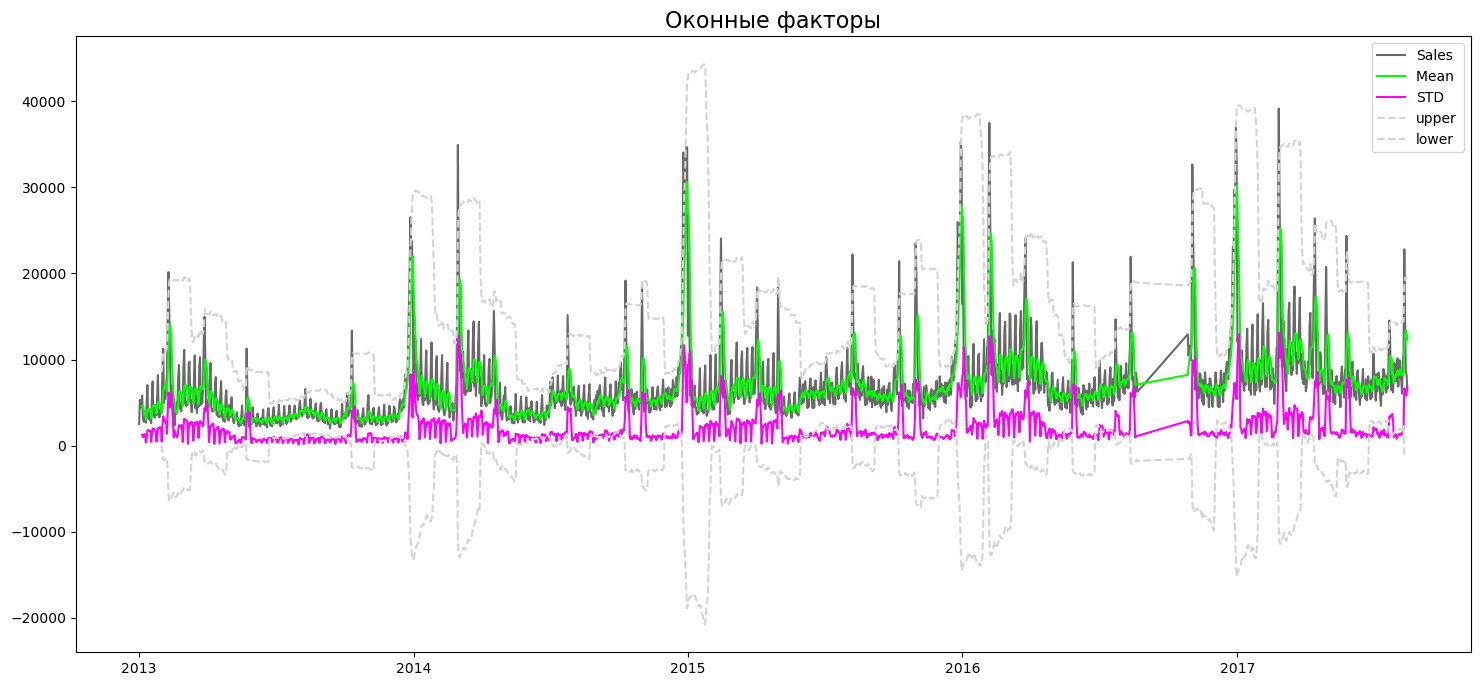

In [9]:
rolling_data = grouped_data.copy()

# построим скользящее среднее и квадратическое отклонение c окном 5
rolling_data['rol_mean_5'] = rolling_data['sales'].rolling(window=5).mean()
rolling_data['rol_std_5'] = rolling_data['sales'].rolling(window=5).std()

# построим линии Боллинджера с окном в 30
rolling_data['upper'] = (
    rolling_data['sales'].rolling(window=30).mean()
    + 3 * rolling_data['sales'].rolling(window=30).std()
)
rolling_data['lower'] = (
    rolling_data['sales'].rolling(window=30).mean()
    - 3 * rolling_data['sales'].rolling(window=30).std()
)

# отобразим оконные факторы на графике
fig, axes = plt.subplots(1, 1, figsize=(18, 8))

axes.plot(rolling_data.index, rolling_data['sales'], color='dimgrey')
axes.plot(rolling_data.index, rolling_data['rol_mean_5'],  color='lime') 
axes.plot(rolling_data.index, rolling_data['rol_std_5'],  color='magenta')
axes.plot(rolling_data.index, rolling_data['upper'], color='lightgrey', linestyle='--') 
axes.plot(rolling_data.index, rolling_data['lower'], color='lightgrey', linestyle='--')

axes.legend(['Sales', 'Mean ', 'STD', 'upper', 'lower'])
axes.set_title('Оконные факторы', fontsize=16);

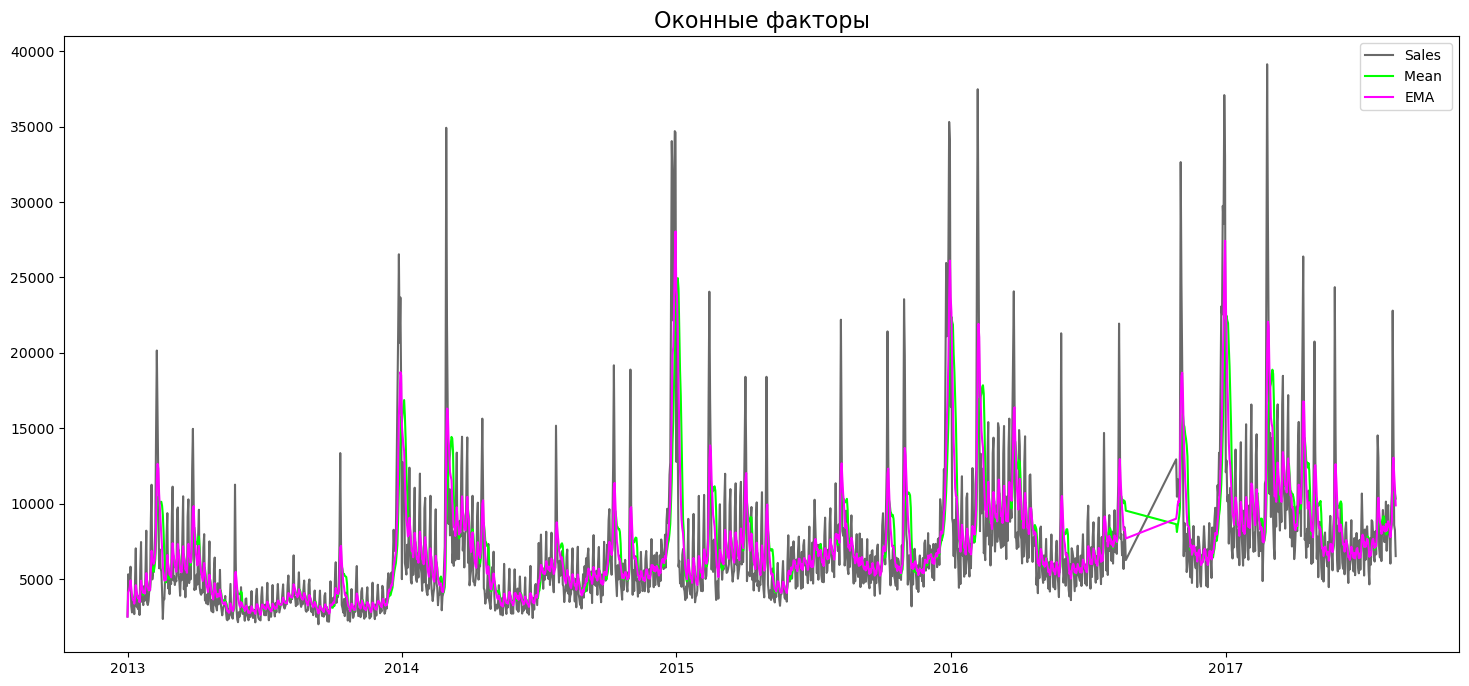

In [10]:
# построим скользящее среднее c окном 10
rolling_data['rol_mean_10'] = rolling_data['sales'].rolling(window=10).mean()
# построим экспоненциально среднее с окном 7
rolling_data['rol_ema_7'] = rolling_data['sales'].ewm(span=7).mean()

# отобразим факторы на графике
fig, axes = plt.subplots(1, 1, figsize=(18, 8))

axes.plot(rolling_data.index, rolling_data['sales'], color='dimgrey')
axes.plot(rolling_data.index, rolling_data['rol_mean_10'],  color='lime') 
axes.plot(rolling_data.index, rolling_data['rol_ema_7'],  color='magenta')

axes.legend(['Sales', 'Mean ', 'EMA'])
axes.set_title('Оконные факторы', fontsize=16);

Необходимо написать свою скользящую функцию, которая будет являться средним арифметическим между максимальным и минимальным значением sales, используя окно 10

In [11]:
def mov_min_max_av(series):
    
    min_value = series.rolling(window=10).min()
    max_value = series.rolling(window=10).max()    
        
    return (min_value + max_value) / 2


rolling_data['av_min_max'] = mov_min_max_av(rolling_data['sales'])

Необходимо построить скользящее среднее с окном 50 и экспоненциальное скользящее среднее с окном 10 (span=10). Укажите индексы датафрейма, на которых одно скользящее пересекается с другим. Для этого вычтите из одно скользящего среднего другое, возьмите знак этой разности (np.sign), продифференциируйте его (diff()) и оставьте только те точки, где результат дифференциирования не равен нулю.

In [12]:
rolling_data['dif_ma10_ema_50'] = np.sign(
    rolling_data['sales'].rolling(window=50).mean() 
    -  rolling_data['sales'].ewm(span=10).mean()    
).diff()

mask = rolling_data['dif_ma10_ema_50'] != 0
date_index = rolling_data[mask].index

date_index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-04-19', '2017-04-29', '2017-05-02', '2017-05-26',
               '2017-05-30', '2017-06-03', '2017-06-05', '2017-07-02',
               '2017-07-04', '2017-07-15'],
              dtype='datetime64[ns]', name='date', length=178, freq=None)

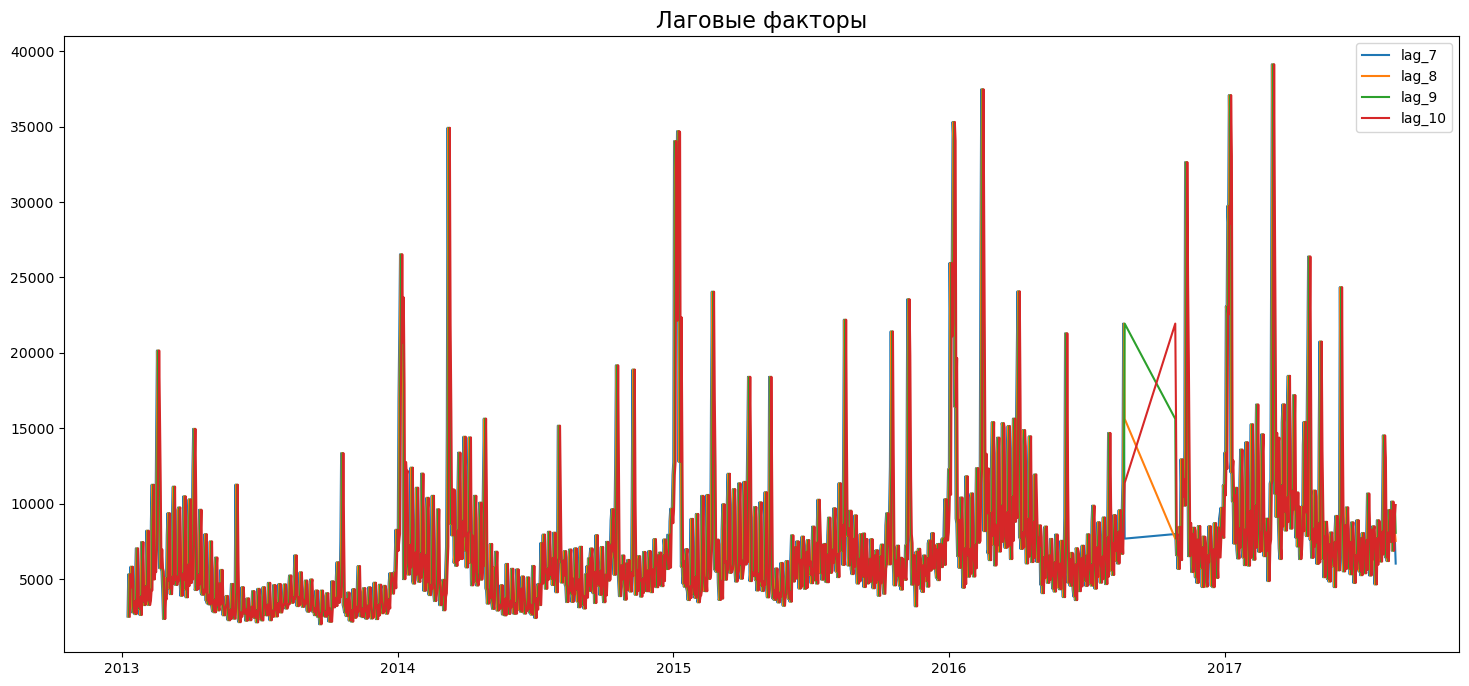

In [13]:
# построим лаговые факторы с 7-го по 10-й предыдущих дня и отобразиv на графике
fig, axes = plt.subplots(1, 1, figsize=(18, 8))
legend = []

for i in range(7,11):
    rolling_data[f'lag_{i}'] = rolling_data['sales'].shift(i)
    legend.append(f'lag_{i}')
    axes.plot(rolling_data.index, rolling_data[f'lag_{i}']) 

axes.legend(legend)
axes.set_title('Лаговые факторы', fontsize=16);

In [14]:
# группируем продажи по товару 103501
mask_103501 = data['item_nbr'] == 103501

gr_data_103501 = (
    data[mask_103501]
    .groupby('date', as_index=False)['unit_sales']
    .sum()
    .rename({'unit_sales': 'sales'}, axis=1)
)

# приводим индексы к стандарту pd.Datetime
gr_data_103501 = gr_data_103501.set_index(pd.DatetimeIndex(gr_data_103501['date'])) 
gr_data_103501 = gr_data_103501.drop('date', axis=1)

gr_data_103501.head()

sales
date             
2013-01-02  185.0
2013-01-03  153.0
2013-01-04  155.0
2013-01-05  160.0
2013-01-06  173.0

In [15]:
# выполним тест Дики-Фуллера
test = adfuller(gr_data_103501['sales'])

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0] > test[4]['5%']:
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.154403058014618
p-value:  0.0007863083913836348
Critical values:  {'1%': -3.4344462031760283, '5%': -2.8633492329988335, '10%': -2.5677331999518147}
ряд стационарен


#### Построим прогноз методом скользящего среднего с окном 6.

In [16]:
def moving_average_forecast(series, window_size):
    
    forecast = []
    
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    
    return np.array(forecast)

In [17]:
# размер окна
ma_window = 6

ma_data = moving_average_forecast(gr_data_103501.values, ma_window)
ma_data = pd.Series(ma_data, index = gr_data_103501[ma_window:].index)

# рассчитаем метрики MSE, MAE, MAPE
print("MSE =", mean_squared_error(gr_data_103501.values[-ma_window:], ma_data[-ma_window:]))
print("MAE =", mean_absolute_error(gr_data_103501.values[-ma_window:], ma_data[-ma_window:]))
print("MAPE =", mean_absolute_percentage_error(gr_data_103501.values[-ma_window:], ma_data[-ma_window:]))

MSE = 287.087962962963
MAE = 13.416666666666666
MAPE = 0.17213844967435177


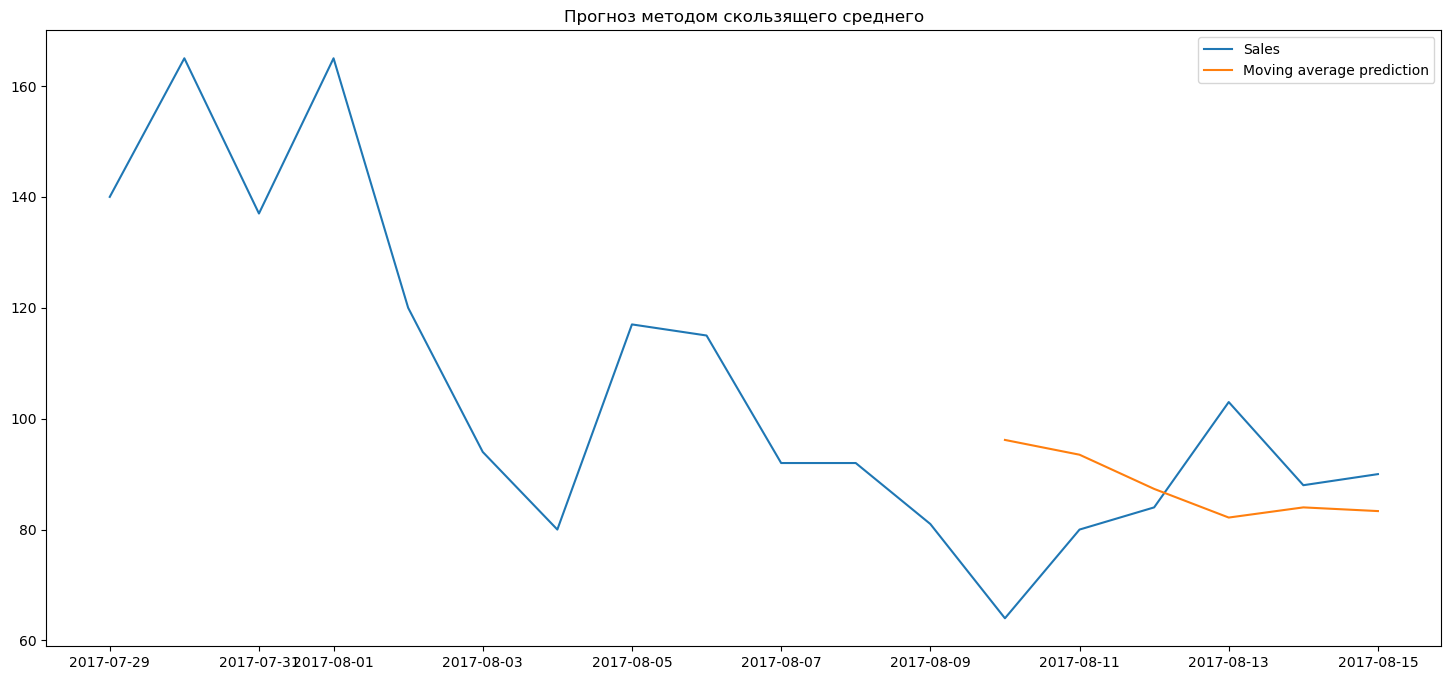

In [18]:
# отобразим прогноз методом скользящего среднего на графике
fig, axes = plt.subplots(1, 1, figsize=(18, 8))

axes.plot(gr_data_103501[-3* ma_window:])
axes.plot(ma_data[-ma_window:])
axes.set_title('Прогноз методом скользящего среднего')
axes.legend(['Sales', 'Moving average prediction']);

#### Построим прогноз методом линейной регрессии

In [19]:
# построим лаговые факторы с 1-го по 6-ой предыдущих дня
for i in range(1,7):
    gr_data_103501[f'lag_{i}'] = gr_data_103501['sales'].shift(i)
    
gr_data_103501 = gr_data_103501.dropna()
    
gr_data_103501.head()

sales  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6
date                                                       
2013-01-08  103.0   98.0  173.0  160.0  155.0  153.0  185.0
2013-01-09   71.0  103.0   98.0  173.0  160.0  155.0  153.0
2013-01-10   83.0   71.0  103.0   98.0  173.0  160.0  155.0
2013-01-11   91.0   83.0   71.0  103.0   98.0  173.0  160.0
2013-01-12  118.0   91.0   83.0   71.0  103.0   98.0  173.0

In [20]:
# отложим 6 последних дней в тестовую выборку для совершения предсказани
predict_size = 6

X_train = gr_data_103501[:-predict_size].drop(['sales'], axis =1)
y_train = gr_data_103501[:-predict_size]['sales']
X_test = gr_data_103501[-predict_size:].drop(['sales'], axis =1)
y_test = gr_data_103501[-predict_size:]['sales']

print('Размер тренировочной выборки:', X_train.shape[0])
print('Размер тестовой выборки:', X_test.shape[0])

Размер тренировочной выборки: 1613
Размер тестовой выборки: 6


In [21]:
# обучим модель линейной регрессии
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_lr = pd.Series(lr.predict(X_test), index=X_test.index)

# рассчитаем метрики MSE, MAE, MAPE
print("MSE =", mean_squared_error(y_test, y_pred_lr))
print("MAE =", mean_absolute_error(y_test, y_pred_lr))
print("MAPE =", mean_absolute_percentage_error(y_test, y_pred_lr))

MSE = 139.24811850562727
MAE = 10.193879920380487
MAPE = 0.12606401062505238


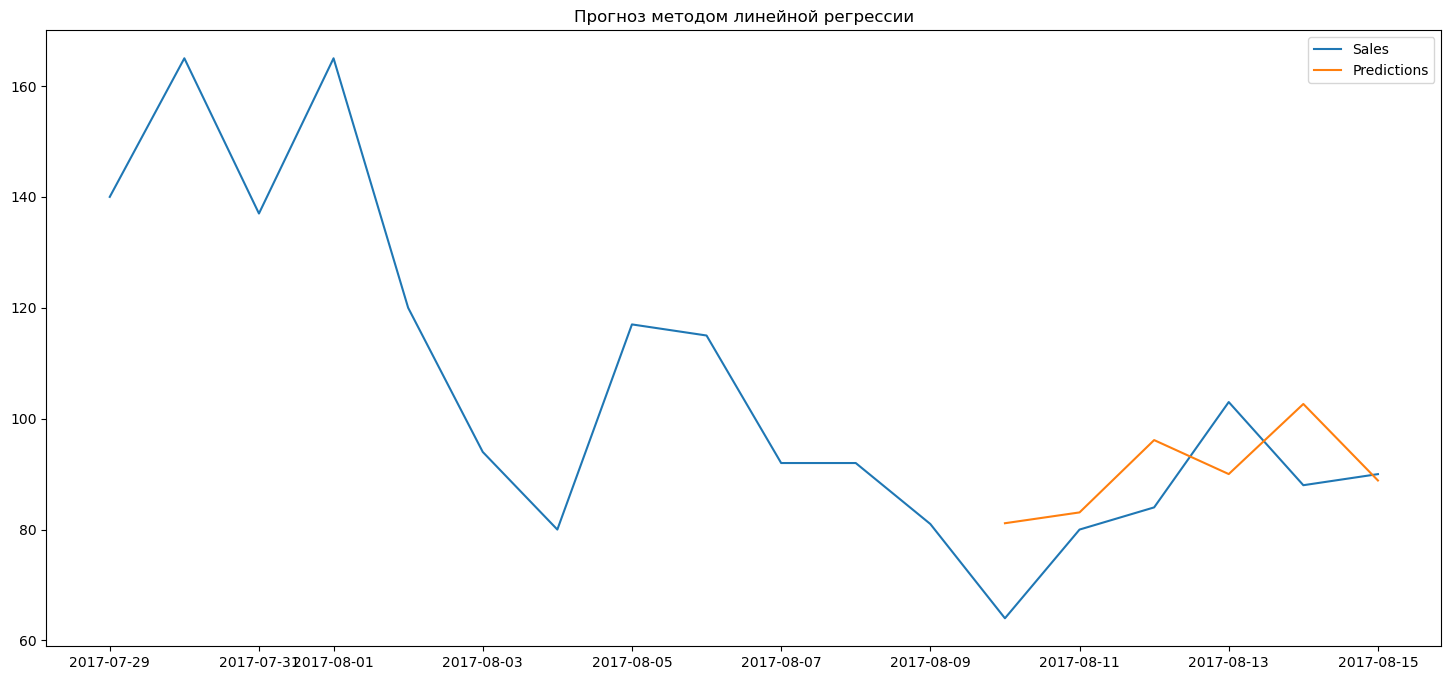

In [22]:
# отобразим прогноз методом линейной регрессии на графике
fig, axes = plt.subplots(1, 1, figsize=(18, 8))

axes.plot(gr_data_103501[-3* ma_window:]['sales'])
axes.plot(y_pred_lr)
axes.set_title('Прогноз методом линейной регрессии')
axes.legend(['Sales', 'Predictions']);

# Построим прогноз методом ARIMA

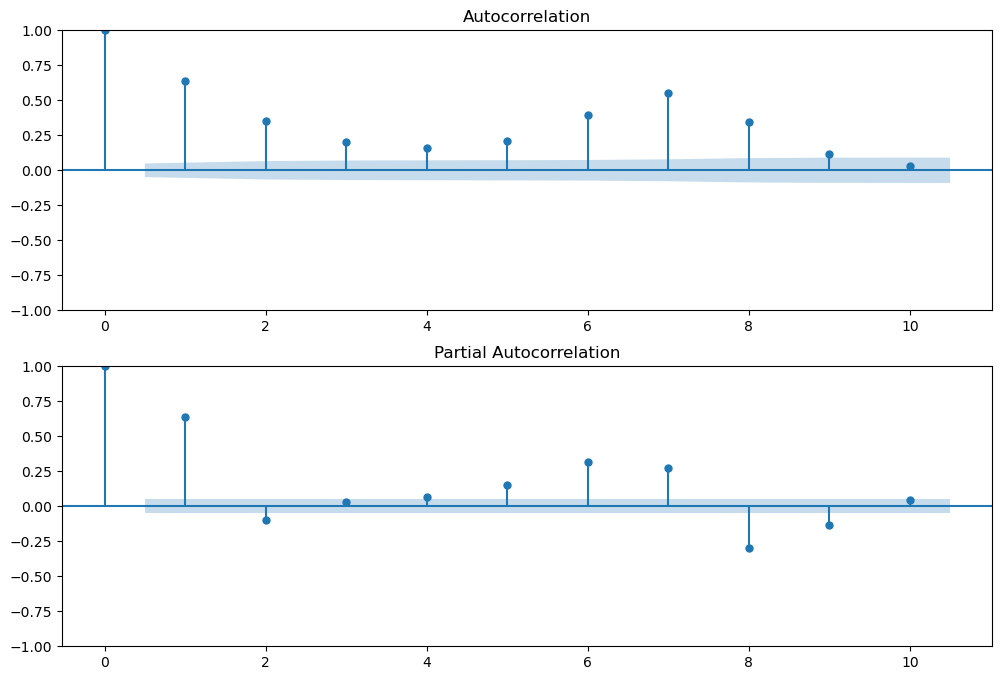

In [23]:
# определим параметры p и q
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gr_data_103501['sales'].values.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gr_data_103501['sales'], lags=10, ax=ax2);

После изучения коррелограмм автокорреляции (ACF) и частичной автокорреляции (PACF) можно предположить, что p = 6 q = 6, так как на соответствующих лагах значения функций резко возрастает.

In [24]:
# обучим модель ARIMA
ar_ma_model = ARIMA(y_train.values.reshape(-1), order=(6, 0, 6))

model = ar_ma_model.fit()

train_size = len(y_train)
test_size = len(y_test)
y_pred_arima = pd.Series(
    model.predict(
        start=train_size,
        end=train_size + test_size - 1,
        dynamic=False
    ), 
    index=y_test.index
)

# рассчитаем метрики MSE, MAE, MAPE
print("MSE =", mean_squared_error(y_test, y_pred_arima))
print("MAE =", mean_absolute_error(y_test, y_pred_arima))
print("MAPE =", mean_absolute_percentage_error(y_test, y_pred_arima))

MSE = 179.53971657939283
MAE = 10.896044419036945
MAPE = 0.12394014322485541


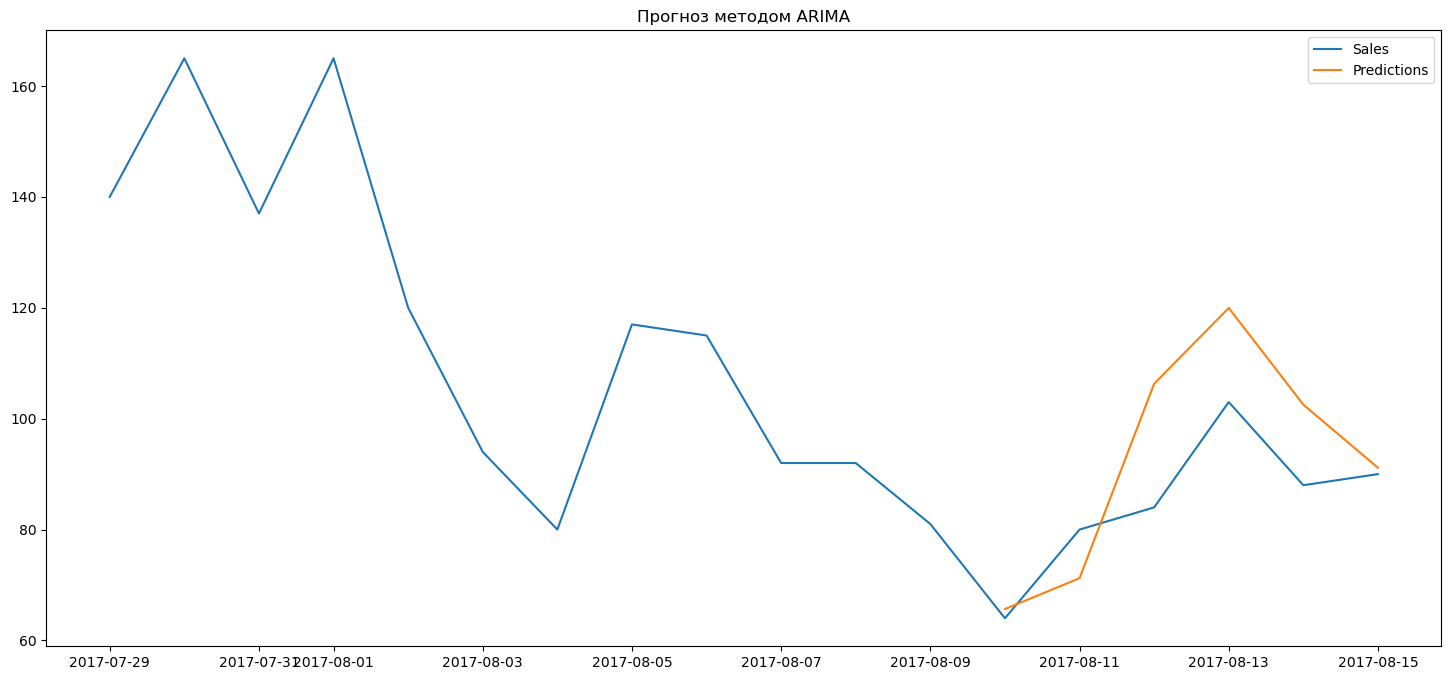

In [25]:
# отобразим прогноз методом ARIMA на графике
fig, axes = plt.subplots(1, 1, figsize=(18, 8))

axes.plot(gr_data_103501[-3* ma_window:]['sales'])
axes.plot(y_pred_arima)
axes.set_title('Прогноз методом ARIMA')
axes.legend(['Sales', 'Predictions']);

**Вывод**: после изучения полученных результатов видим, что наилучшие результаты с точки зрения метрик качества показали две модели линейной регрессии и ARIMA. Однако при визуальном анализе построенных прогнозов видим, что модель ARIMA лучше воспроизводит изменения временного ряда, на основании чего можно сделать предположение о том, что в остатке остался именно "белый шум".

# Построим прогноз с помощью библиотеки FBProphet

In [56]:
# сгруппируем продажи по дате
gr_all_data = (
    data
    .groupby('date', as_index=False)['unit_sales']
    .sum()
    .rename({'unit_sales': 'sum_unit_sales'}, axis=1)
)

# отобразим временной ряд на графике
py.iplot([
    go.Scatter(
        x=gr_all_data['date'],
        y=gr_all_data['sum_unit_sales']
    )
])

Из построенного графика видим явное влияние сезонности и праздников в декабре и январе каждого года.

In [57]:
train_size = gr_all_data.shape[0]

# переменуем столбцы датафрейма
gr_all_data.columns = ['ds', 'y']

gr_all_data.head()

ds           y
0  2013-01-01    2511.619
1  2013-01-02  496092.418
2  2013-01-03  361429.231
3  2013-01-04  354459.677
4  2013-01-05  477350.121

In [58]:
# обучим модель Prophet
pr_model = Prophet()

pr_model.fit(gr_all_data)

future = pr_model.make_future_dataframe(periods=365)

# строим прогноз
forecast = pr_model.predict(future)

# рассчитаем метрику RMSE и MAPE
print('RMSE =%f' % np.sqrt(np.mean((forecast.loc[:train_size - 1, 'yhat'] - gr_all_data['y'])**2)) )
print("MAPE =", mean_absolute_percentage_error(gr_all_data['y'], forecast.loc[:train_size - 1, 'yhat']))

forecast.head()

11:58:32 - cmdstanpy - INFO - Chain [1] start processing
11:58:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE =108084.526952
MAPE = 0.3627940079111564


ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 2013-01-01  335515.877479  243854.118677  517285.754394  335515.877479   
1 2013-01-02  335880.156766  249254.327824  526025.035685  335880.156766   
2 2013-01-03  336244.436053  157803.441101  433089.696441  336244.436053   
3 2013-01-04  336608.715340  216635.535744  485582.274934  336608.715340   
4 2013-01-05  336972.994627  398391.814005  673887.436782  336972.994627   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  335515.877479    43399.477956          43399.477956          43399.477956   
1  335880.156766    55417.734162          55417.734162          55417.734162   
2  336244.436053   -44207.127232         -44207.127232         -44207.127232   
3  336608.715340    18836.907088          18836.907088          18836.907088   
4  336972.994627   198410.759916         198410.759916         198410.759916   

          weekly   weekly_lower   weekly_upper         yearly   yearly_lower  \
0  -68157.771510  -68157.771510  -68157.771510  111557.249466  111557.249466   
1  -44204.882248  -44204.882248  -44204.882248   99622.616410   99622.616410   
2 -131875.877701 -131875.877701 -131875.877701   87668.750469   87668.750469   
3  -57037.126739  -57037.126739  -57037.126739   75874.033827   75874.033827   
4  134004.018786  134004.018786  134004.018786   64406.741129   64406.741129   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0  111557.249466                   0.0                         0.0   
1   99622.616410                   0.0                         0.0   
2   87668.750469                   0.0                         0.0   
3   75874.033827                   0.0                         0.0   
4   64406.741129                   0.0                         0.0   

   multiplicative_terms_upper           yhat  
0                         0.0  378915.355436  
1                         0.0  391297.890928  
2                         0.0  292037.308821  
3                         0.0  355445.622428  
4                         0.0  535383.754542

In [59]:
# отобразим прогноз на графике
py.iplot([
    go.Scatter(x=gr_all_data['ds'], y=gr_all_data['y'], name='Sales'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

Поэкспериментируем с коэффициентом changepoint_prior_scale (переберите 3-5 значений, больше/меньше 0,5) и посмотрим, как изменится тренд.

In [60]:
scales_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3]

plots_list = [
    go.Scatter(x=gr_all_data['ds'], y=gr_all_data['y'], name='Sales'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
]

for scale in scales_list: 
    # обучим модель Prophet для каждого значения коэффициента
    pr_model_tr = Prophet(changepoint_prior_scale=scale)
    pr_model_tr.fit(gr_all_data)
    future_tr = pr_model_tr.make_future_dataframe(periods=365)
    forecast_tr = pr_model_tr.predict(future_tr)
    
    plots_list.append(go.Scatter(x=forecast_tr['ds'], y=forecast_tr['trend'], name=f'Trend_scale_{scale}'))

# отобразим результаты на графике
py.iplot(plots_list)

11:58:32 - cmdstanpy - INFO - Chain [1] start processing
11:58:32 - cmdstanpy - INFO - Chain [1] done processing
11:58:33 - cmdstanpy - INFO - Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing
11:58:33 - cmdstanpy - INFO - Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] done processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:35 - cmdstanpy - INFO - Chain [1] done processing
11:58:35 - cmdstanpy - INFO - Chain [1] start processing
11:58:35 - cmdstanpy - INFO - Chain [1] done processing
11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:36 - cmdstanpy - INFO - Chain [1] done processing


На очновании полученных данных видим, что со значениями по умолчанию тренд недообучен, при этом после значения коэффициента 0,5 значительных изменений тренда не наблюдается. Таким образом во избежание переобучения тренда, в качестве оптимального значения коэффициента будем использовать 0,5.

In [61]:
# обучим модель Prophet с подобранным коэффициентом
pr_model_tr_opt = Prophet(changepoint_prior_scale=0.5)

pr_model_tr_opt.fit(gr_all_data)

future_tr_opt = pr_model_tr_opt.make_future_dataframe(periods=365)

# строим прогноз
forecast_tr_opt = pr_model_tr_opt.predict(future_tr_opt)

# рассчитаем метрики RMSE и MAPE
print('RMSE: %f' % np.sqrt(np.mean((forecast_tr_opt.loc[:train_size - 1, 'yhat'] - gr_all_data['y'])**2)) )
print("MAPE =", mean_absolute_percentage_error(gr_all_data['y'], forecast_tr_opt.loc[:train_size - 1, 'yhat']))

11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:37 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 98585.657851
MAPE = 0.3421587023588902


In [62]:
# отобразим прогноз на графике
py.iplot([
    go.Scatter(x=gr_all_data['ds'], y=gr_all_data['y'], name='Sales'),
    go.Scatter(x=forecast_tr_opt['ds'], y=forecast_tr_opt['yhat'], name='Prediction'),
    go.Scatter(x=forecast_tr_opt['ds'], y=forecast_tr_opt['trend'], name='Trend')
])

In [63]:
# добавим в модель месячную сезонность
pr_model_s = Prophet(changepoint_prior_scale=0.5)
pr_model_s.add_seasonality(name='monthly', period=30.5, fourier_order=5)

pr_model_s.fit(gr_all_data)

future_s = pr_model_s.make_future_dataframe(periods=365)

# строим прогноз
forecast_s = pr_model_s.predict(future_s)

# рассчитаем метрики RMSE и MAPE
print('RMSE: %f' % np.sqrt(np.mean((forecast_s.loc[:train_size - 1, 'yhat'] - gr_all_data['y'])**2)) )
print("MAPE =", mean_absolute_percentage_error(gr_all_data['y'], forecast_s.loc[:train_size - 1, 'yhat']))

11:58:37 - cmdstanpy - INFO - Chain [1] start processing
11:58:37 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 91893.852986
MAPE = 0.3588906036036827


In [64]:
# отобразим прогноз на графике
py.iplot([
    go.Scatter(x=gr_all_data['ds'], y=gr_all_data['y'], name='Sales'),
    go.Scatter(x=forecast_s['ds'], y=forecast_s['yhat'], name='Prediction'),
    go.Scatter(x=forecast_s['ds'], y=forecast_s['trend'], name='Trend')
])

Построенная модель стала лучше описывать сезонные колебания временного ряда. Однако влияние празднико в декабре и январе по прежнему не учитывается. Поэтому добавим данные о праздниках в модель.

In [65]:
# загрузим информацию о праздниках
data_holidays = pd.read_csv('data/holidays_events.csv')

mask = data_holidays['transferred'] == False
holidays = data_holidays[mask][['description', 'date']]
holidays.columns = ['holiday', 'ds']

holidays.head()

holiday          ds
0             Fundacion de Manta  2012-03-02
1  Provincializacion de Cotopaxi  2012-04-01
2            Fundacion de Cuenca  2012-04-12
3      Cantonizacion de Libertad  2012-04-14
4      Cantonizacion de Riobamba  2012-04-21

In [66]:
# добавим данные о праздниках в модель
pr_model_h = Prophet(changepoint_prior_scale=0.5, holidays=holidays)
pr_model_h.add_seasonality(name='monthly', period=30.5, fourier_order=5)

pr_model_h.fit(gr_all_data)

future_h = pr_model_h.make_future_dataframe(periods=365)

# строим прогноз
forecast_h = pr_model_h.predict(future_h)

# рассчитаем метрики RMSE и MAPE
print('RMSE: %f' % np.sqrt(np.mean((forecast_h.loc[:train_size - 1, 'yhat'] - gr_all_data['y'])**2)) )
print("MAPE =", mean_absolute_percentage_error(gr_all_data['y'], forecast_h.loc[:train_size - 1, 'yhat']))

11:58:38 - cmdstanpy - INFO - Chain [1] start processing
11:58:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 74690.917716
MAPE = 0.2017790992518514


In [67]:
# отобразим прогноз на графике
py.iplot([
    go.Scatter(x=gr_all_data['ds'], y=gr_all_data['y'], name='Sales'),
    go.Scatter(x=forecast_h['ds'], y=forecast_h['yhat'], name='Prediction'),
    go.Scatter(x=forecast_h['ds'], y=forecast_h['trend'], name='Trend')
])

**Вывод**: из полученных данных вмдим, что итоговая модель достаточно хорошо аппроксимирует временной ряд. Таким образом добавление информации о праздниках позволило значительно улучшить качество построенной модели Prophet. 

# Построим прогноз с помощью алгоритмов бустинги/деревья.

In [68]:
gr_all_data.columns = ['date', 'sales']

gr_all_data['date'] = pd.to_datetime(gr_all_data['date'])

In [69]:
# разобьйем временной ряд на тестовую и тренировучную выборки
train_mask = gr_all_data['date'] < '2017-01-01'
train = gr_all_data[train_mask]
test_mask = gr_all_data['date'] >= '2017-01-01'
test = gr_all_data[test_mask]

print("Размер тренировочной выборки:", train.shape[0])
print("Размер тестовой выборки", test.shape[0])

Размер тренировочной выборки: 1457
Размер тестовой выборки 227


In [70]:
def create_features(data, label=None): 
    df = data.copy()    
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    if label:
        X = df.drop([label, 'date'], axis=1)
        y = df[label]
        return X, y
    else:
        return df.drop([label, 'date'], axis=1)

In [71]:
# создадим временные признаки
X_train, y_train = create_features(train, label='sales')
X_test, y_test = create_features(test, label='sales')

In [72]:
# обучим модель XGBRegressor
xgb_reg = xgb.XGBRegressor(n_estimators=1000)

xgb_reg.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=50,
    verbose=False
)

# построим прогноз
y_pred_xgb = xgb_reg.predict(X_test)

# рассчитаем метрики MSE, MAE, MAPE
print("MSE =", mean_squared_error(y_test, y_pred_xgb))
print("MAE =", mean_absolute_error(y_test, y_pred_xgb))
print("MAPE =", mean_absolute_percentage_error(y_test, y_pred_xgb))

MSE = 22009696501.496437
MAE = 108459.88256828193
MAPE = 0.4872119944835388


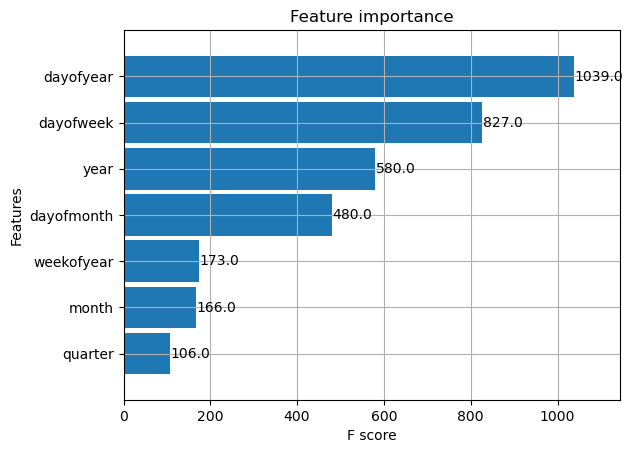

In [73]:
# отобразим важность признаков
_ = plot_importance(xgb_reg, height=0.9)

Из построенного графика видим что наиболее значимым при построение прогноза является признак день года, затем следует день недели. На основании изложенного можно сделать предположение о наличии годовой и недельной цикличности в продажах. Наименее важным признаком является квартал.

In [74]:
# отобразим прогноз на графике
py.iplot([
    go.Scatter(x=test['date'], y=test['sales'], name='Sales'),
    go.Scatter(x=test['date'], y=y_pred_xgb, name='Prediction')    
])

In [75]:
# обучим модель CatBoost
cat_reg = CatBoostRegressor(n_estimators=1000)

cat_reg.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=50,
    verbose=False
)

# построим прогноз
y_pred_cat = cat_reg.predict(X_test)

# рассчитаем метрики MSE, MAE, MAPE
print("MSE =", mean_squared_error(y_test, y_pred_cat))
print("MAE =", mean_absolute_error(y_test, y_pred_cat))
print("MAPE =", mean_absolute_percentage_error(y_test, y_pred_cat))

MSE = 17011398656.475328
MAE = 99896.19690947609
MAPE = 0.4058439261268387


In [76]:
# отобразим прогноз на графике
py.iplot([
    go.Scatter(x=test['date'], y=test['sales'], name='Sales'),
    go.Scatter(x=test['date'], y=y_pred_cat, name='Prediction')    
])

**Вывод**: из полученных данных видим, что без в данной конфигурации датасета модели XGBRegressor и CatBoost показывают низкое качество, при этом модель модель CatBoost лучше аппроксимирует временной ряд.

In [77]:
# добавим в данные информацию о праздничных днях
gr_all_data = gr_all_data.merge(
    holidays,
    how='left',
    left_on=pd.to_datetime(gr_all_data['date']),
    right_on='ds'
).drop('ds', axis=1)

# преобразуем категориальный признак
gr_all_data = pd.get_dummies(gr_all_data)

# разобьйем датафрейм на тестовую и тренировучную выборки
train_mask = gr_all_data['date'] < '2017-01-01'
train_hol = gr_all_data[train_mask]
test_mask = gr_all_data['date'] >= '2017-01-01'
test_hol = gr_all_data[test_mask]

# создадим временные признаки
X_train_hol, y_train_hol = create_features(train_hol, label='sales')
X_test_hol, y_test_hol = create_features(test_hol, label='sales')

In [78]:
# обучим модель XGBRegressor
xgb_reg_hol = xgb.XGBRegressor(n_estimators=1000)

xgb_reg_hol.fit(
    X_train_hol, 
    y_train_hol,
    eval_set=[
        (X_train_hol, y_train_hol), 
        (X_test_hol, y_test_hol)
    ],
    early_stopping_rounds=50,
    verbose=False
)

# построим прогноз
y_pred_xgb_hol = xgb_reg_hol.predict(X_test_hol)

# рассчитаем метрики MSE, MAE, MAPE
print("MSE =", mean_squared_error(y_test_hol, y_pred_xgb_hol))
print("MAE =", mean_absolute_error(y_test_hol, y_pred_xgb_hol))
print("MAPE =", mean_absolute_percentage_error(y_test_hol, y_pred_xgb_hol))

MSE = 19046485755.367256
MAE = 104973.92492857143
MAPE = 0.501587124448191


In [79]:
# обучим модель CatBoost
cat_reg_hol = CatBoostRegressor(n_estimators=1000)

cat_reg_hol.fit(
    X_train_hol, 
    y_train_hol,
    eval_set=[
        (X_train_hol, y_train_hol), 
        (X_test_hol, y_test_hol)
    ],
    early_stopping_rounds=50,
    verbose=False
)

# построим прогноз
y_pred_cat_hol = cat_reg_hol.predict(X_test_hol)

# рассчитаем метрики MSE, MAE, MAPE
print("MSE =", mean_squared_error(y_test_hol, y_pred_cat_hol))
print("MAE =", mean_absolute_error(y_test_hol, y_pred_cat_hol))
print("MAPE =", mean_absolute_percentage_error(y_test_hol, y_pred_cat_hol))

MSE = 18572799148.253742
MAE = 99128.10360792528
MAPE = 0.5018407851139612


In [80]:
# добавим в данные лаговые факторы
for i in range(1, 227):
    gr_all_data[f'lag_{i}'] = gr_all_data['sales'].shift(i)

gr_all_data = gr_all_data.dropna()

# разобьйем датафрейм на тестовую и тренировучную выборки
train_rol = gr_all_data[train_mask]
test_rol = gr_all_data[test_mask]

# создадим временные признаки
X_train_rol, y_train_rol = create_features(train_rol, label='sales')
X_test_rol, y_test_rol = create_features(test_rol, label='sales')

In [81]:
# обучим модель XGBRegressor
xgb_reg_rol = xgb.XGBRegressor(n_estimators=1000)

xgb_reg_rol.fit(
    X_train_rol, 
    y_train_rol,
    eval_set=[
        (X_train_rol, y_train_rol), 
        (X_test_rol, y_test_rol)
    ],
    early_stopping_rounds=50,
    verbose=False
)

# построим прогноз
y_pred_xgb_rol = xgb_reg_rol.predict(X_test_rol)

# рассчитаем метрики MSE, MAE, MAPE
print("MSE =", mean_squared_error(y_test_rol, y_pred_xgb_rol))
print("MAE =", mean_absolute_error(y_test_rol, y_pred_xgb_rol))
print("MAPE =", mean_absolute_percentage_error(y_test_rol, y_pred_xgb_rol))

MSE = 18270529222.056232
MAE = 82894.15703463202
MAPE = 0.5075539196615053


In [82]:
# обучим модель CatBoost
cat_reg_rol = CatBoostRegressor(n_estimators=1000)

cat_reg_rol.fit(
    X_train_rol, 
    y_train_rol,
    eval_set=[
        (X_train_rol, y_train_rol), 
        (X_test_rol, y_test_rol)
    ],
    early_stopping_rounds=50,
    verbose=False
)

# построим прогноз
y_pred_cat_rol = cat_reg_rol.predict(X_test_rol)

# рассчитаем метрики MSE, MAE, MAPE
print("MSE =", mean_squared_error(y_test_rol, y_pred_cat_rol))
print("MAE =", mean_absolute_error(y_test_rol, y_pred_cat_rol))
print("MAPE =", mean_absolute_percentage_error(y_test_rol, y_pred_cat_rol))

MSE = 14605368551.006374
MAE = 72131.13744020922
MAPE = 0.4554982942543543


**Вывод**: на основании полученных данных, видим, что добавление информации о праздниках и добавление лаговых признаков, привело только к снижению метрик качества обученных моделей.